# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [8]:
student1 = "Remy Pétremand"
student2 = "Arthur Père"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [3]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io
import math
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
from keras import optimizers
# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
#np.random.seed(hash(student1 + student2) % 2**32)
np.random.seed(hash(250970 + 245788) % 2**32)

subset_of_classes = np.random.choice(range(10), 5, replace = False)

Using TensorFlow backend.


### Plotting

In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):# 6 , 4 normalement
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [5]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

# flatten: returns a copy of the array collapsed into 1D
# transpose()
# reshape downsapled into 16*16 = 256 and the shap
# grey.shape[2] -> takes the 3rd element of the shape of the grey variable

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)



data_train = scipy.io.loadmat('housenumbers/train_32x32.mat')
data_test = scipy.io.loadmat('housenumbers/test_32x32.mat')


x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [6]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

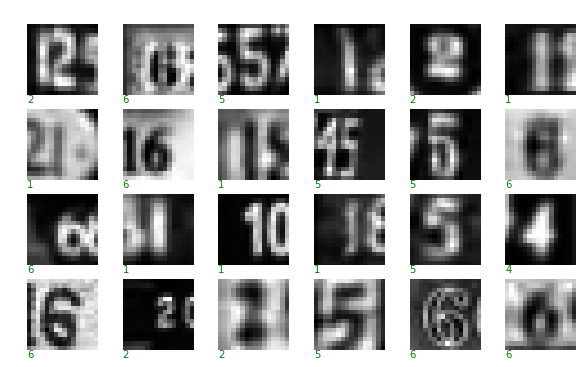

In [33]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes);


To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [7]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [19]:
def build_no_hidden_layers_model():
    model = Sequential() # set up empty model
    model.add(Dense(5, input_dim=256, activation='softmax', name = 'Y'))#input_shape = x_train.shape[1:]
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    # model.summary()
    return model

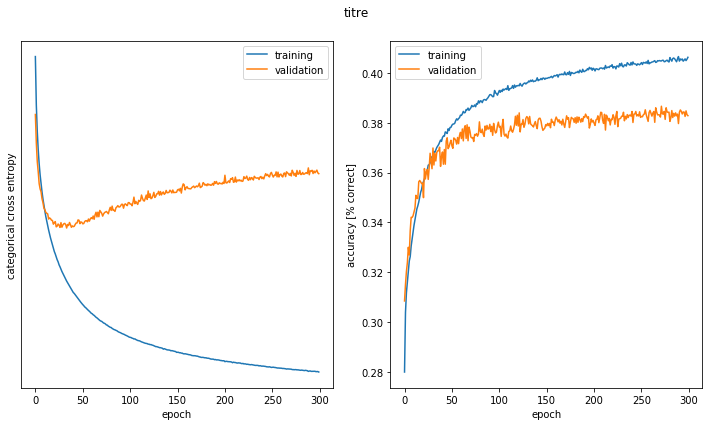

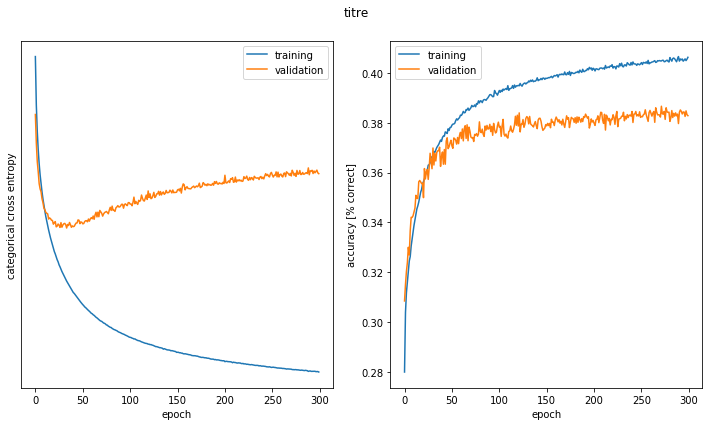

In [20]:
model = build_no_hidden_layers_model()

history = model.fit(x_train, y_train, batch_size=128, epochs= 300,  verbose=0,  validation_data = (x_test, y_test))
plot_history(history,'titre')

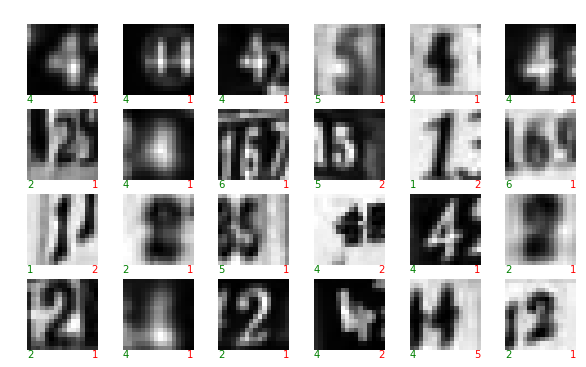

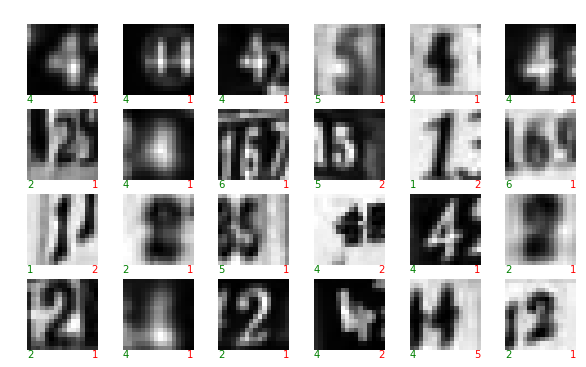

In [21]:
yhat_test = model.predict(x_test)

#we have to find the maximum of each entry
error_indices = []
for i in range(0, len(yhat_test)):
    max_index_yhat = np.argmax(yhat_test[i])
    max_index_test = np.argmax(y_test[i])
    if max_index_yhat != max_index_test:
        error_indices.append(i)
        

plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

In [37]:
def fit_model_sgd(learning_rate = 0.01):
    #build the model with SGD and a hidden layer
    model_sgd = Sequential() # set up empty model
    model_sgd.add(Dense(64, input_dim = 256, activation = 'relu', name = 'H1'))
    model_sgd.add(Dense(5, activation='softmax', name = 'Y'))
    #compile the model
    model_sgd.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.SGD(lr=learning_rate),
                  metrics=['accuracy'])
    #print the summary of the model
    model_sgd.summary()
    #fit the model
    history = model_sgd.fit(x_train, y_train, epochs=50, batch_size=128, verbose=0,  validation_data = (x_test, y_test))
    return history

In [20]:
learning_rates = [0.001,0.01,0.1,1,10]

histories = []

for i in learning_rates:
    history = fit_model_sgd(learning_rate = i)
    histories.append(history)
    #plot_history(history, 'learning rate ' + str(i))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
La

In [36]:
def plot_history2(history_list, title):
    color_list = ["blue", "red", "green","black", "yellow"]
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    for i in range(0,len(history_list)):
        ax1.plot(history_list[i].history['val_loss'],
                 ':', 
                 fillstyle='none', 
                 color=color_list[i], 
                 label = "validation lr " + str(learning_rates[i]))
       
        ax2.plot(history_list[i].history['val_acc'],
                 ':' ,
                 fillstyle='none',
                 color=color_list[i], 
                 label = "validation lr " + str(learning_rates[i]))
    finalize_standardplot(fig, ax1, ax2)
    return fig

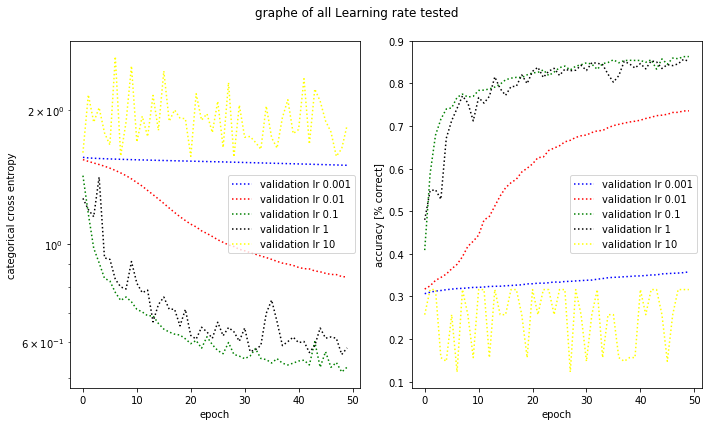

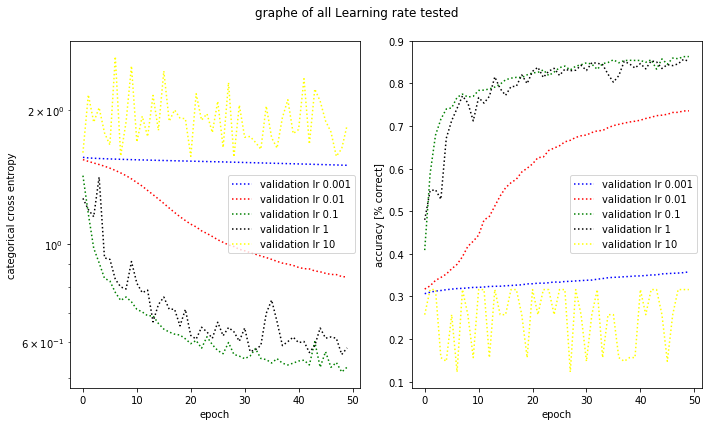

In [37]:
plot_history2(histories, 'graphe of all Learning rate tested')

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) A very small learning rate is none optimal as the changes between epochs will be too small and we will need too many iterations (epochs) to converge to the best values.

B) A large learning rate cause the loss function to fluctuate around the minimum or even to diverge and thus interfere with convergence.

In [38]:
def build_adam(learning_rate = 0.001):
    model_adam = Sequential() # set up empty model
    model_adam.add(Dense(64, input_dim = 256, activation = 'relu', name = 'H1'))
    model_adam.add(Dense(5, activation='softmax', name = 'Y'))
    adam = keras.optimizers.Adam(lr=learning_rate)
    model_adam.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
    model_adam.summary()
    history_adam = model_adam.fit(x_train, y_train, epochs= 50, batch_size=128, verbose=0, validation_data = (x_test, y_test))
    
    return history_adam

In [39]:
history_adam = build_adam(learning_rate=0.001)
#plot_history(history_adam, 'Model with one hidden layer and adam optimizer (lr = 0.001)')
history_sgd = fit_model_sgd(learning_rate = 0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


In [40]:
def plot_history_SGD_ADAM(history1,history2, title):
    #history1 = sgd
    #history2 = adam
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history1.history['loss'],':', fillstyle='none', color="blue", 
             label = "training with SGD")
    ax1.plot(history1.history['val_loss'], '--', fillstyle='none', color="blue", 
             label = "validation with SGD")
    ax1.plot(history2.history['loss'],':', fillstyle='none', color="orange", 
             label = "training with Adam")
    ax1.plot(history2.history['val_loss'], '--', fillstyle='none', color="orange",  
             label = "validation with Adam")
    ax2.plot(history1.history['acc'],':' ,fillstyle='none',color="blue", 
             label = "training with SGD")
    ax2.plot(history1.history['val_acc'], '--', fillstyle='none', color="blue",
             label = "validation with SGD")
    ax2.plot(history2.history['acc'], ':', fillstyle='none', color="orange",
             label = "training with Adam")
    ax2.plot(history2.history['val_acc'], '--', fillstyle='none', color="orange", 
             label = "validation with Adam")
    finalize_standardplot(fig, ax1, ax2)
    return fig

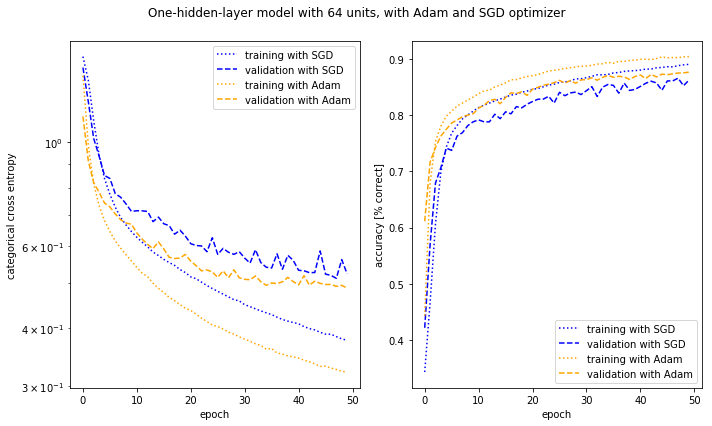

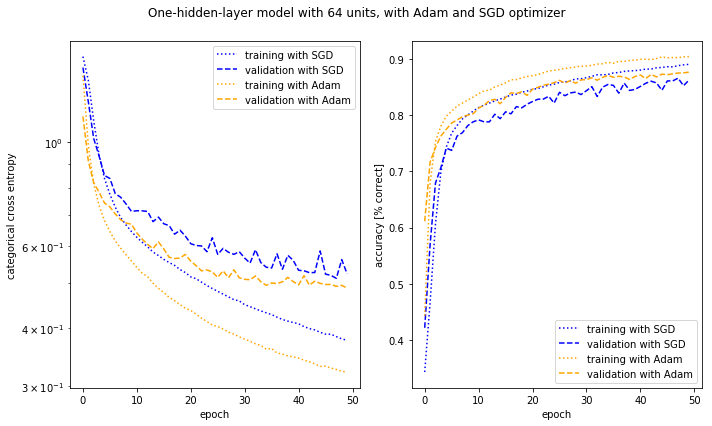

In [41]:
#plot the history of the SGD optimizer and the adam optimizer.
# e chose the learning rate (lr) = 0.1 for the SGD and 0.001 for the ADAM

plot_history_SGD_ADAM(history1 = history_sgd, history2 = history_adam, title='One-hidden-layer model with 64 units, with Adam and SGD optimizer')

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

In [35]:
def build_one_hidden_layer_model(learning_rate = 0.001):
    #the model
    model = Sequential() # set up empty model
    model.add(Dense(64, input_dim = 256, activation = 'relu', name = 'H1'))
    model.add(Dense(5, activation='softmax', name = 'Y'))

    adams = keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=adams, metrics=['accuracy'])
    model.summary()
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


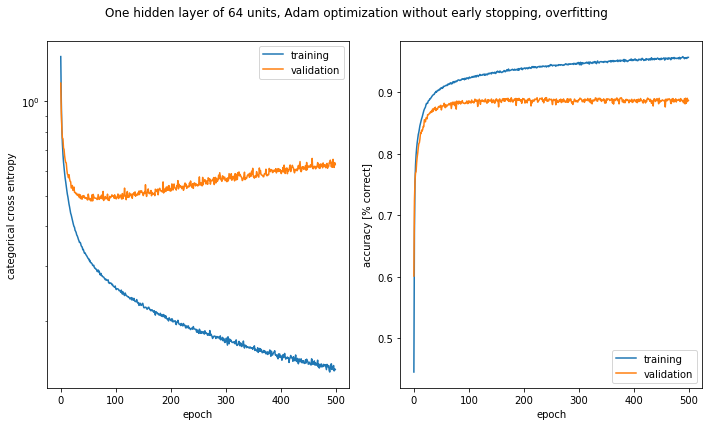

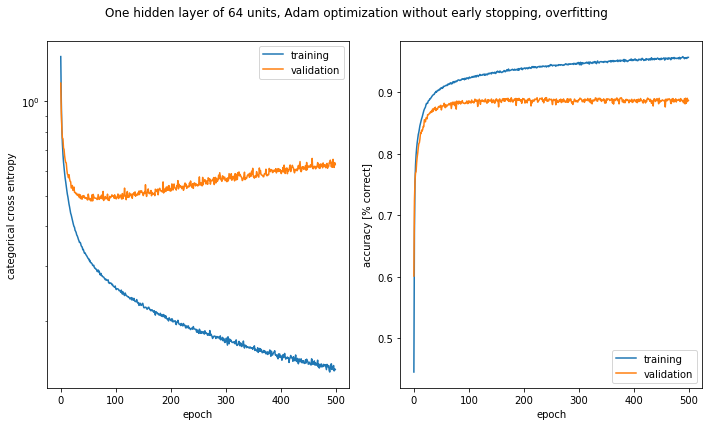

In [36]:
model_one = build_one_hidden_layer_model(learning_rate=0.001)
history_one = model_one.fit(x_train, y_train, epochs=500, batch_size=128, verbose=0, validation_data = (x_test, y_test))
plot_history(history_one,'One hidden layer of 64 units, Adam optimization without early stopping, overfitting')

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: The model starts to overfit at 70 epoch, because the validation loss stops to decrease while the training loss keeps decreasing.

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: For the loss curves, the overfitting is visible at 70 epoch because the validation loss stops decreasing and begins to increase while the training loss keep decreasing. As for the accuracy curves, the overfitting is visible at 70 epoch because the validation accuracy stops increasing and keeps more or less constant while the training accuracy keeps increasing.

## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

In [78]:
def build_one_hidden_layer_model(learning_rate = 0.001, hidden_units = 64):
    #the model
    model = Sequential() # set up empty model
    model.add(Dense(hidden_units, input_dim = 256, activation = 'relu', name = 'H1'))
    model.add(Dense(5, activation='softmax', name = 'Y'))

    adams = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer=adams, metrics=['accuracy'])
    #model.summary()
    return model

In [39]:
# without early_stopping
start = time.time()
print("Start of the script execution...")


h_range = [10,50,100,500,1000]
iterations = range(0,10)

losses_100 = np.empty([ len(iterations),len(h_range) ])
accuracies_100 = np.empty([ len(iterations),len(h_range) ])

for h in range(0,len(h_range)):
    for i in iterations:
        #print('h =',h_range[h],' and i =',i)
        model_one = build_one_hidden_layer_model(learning_rate=0.001, hidden_units = h_range[h])
        history_one = model_one.fit(x_train, y_train, epochs=100, batch_size=128, verbose=0, validation_data = (x_test, y_test))
        last_loss = history_one.history['val_loss'][-1]
        last_acc = history_one.history['val_acc'][-1]
        losses_100[i,h] = last_loss
        accuracies_100[i,h] = last_acc
        
print("End of the execution !")
end = time.time()
print("Execution time : {} seconds.".format(math.ceil(end - start)))


Start of the script execution...
End of the execution !
Execution time : 10057 seconds.


TypeError: cannot serialize '_io.BufferedReader' object

In [40]:
np.save('E4_saved_losses_100',losses_100)
np.save('E4_saved_acc_100',accuracies_100)

In [89]:
start = time.time()
print("Start of the script execution...")

earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=0, mode='min')
callbacks_list = [earlystop]


h_range = [10,50,100,500,1000]
iterations = range(0,10)

losses_ES = np.empty([ len(iterations),len(h_range) ])
accuracies_ES = np.empty([ len(iterations),len(h_range) ])

for h in range(0,len(h_range)):
    for i in iterations:
        #print('h =',h_range[h],' and i =',i)
        model_one = build_one_hidden_layer_model(learning_rate=0.001, hidden_units = h_range[h])
        history_one = model_one.fit(x_train, y_train, epochs=150, batch_size=128, callbacks = callbacks_list, verbose=0, validation_data = (x_test, y_test))
        last_loss = history_one.history['val_loss'][-1]
        last_acc = history_one.history['val_acc'][-1]
        losses_ES[i,h] = last_loss
        accuracies_ES[i,h] = last_acc
        
print("End of the execution !")
end = time.time()
print("Execution time : {} seconds.".format(math.ceil(end - start)))


Start of the script execution...
End of the execution !
Execution time : 6159 seconds.


In [90]:
np.save('E4_saved_losses_ES',losses_ES)
np.save('E4_saved_acc_ES',accuracies_ES)

In [72]:
def boxplot_plot(loss, acc, title):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    
    ax1.set_ylabel('Final losses')
    ax1.set_xlabel('Number of hidden neurons')
    ax1.boxplot(loss)
    plt.setp(ax1, xticks=[1,2,3,4,5], xticklabels=['10','50','100','500','1000'])
    ax2.set_ylabel('Final accuracy')
    ax2.set_xlabel('Number of hidden neurons')
    ax2.boxplot(acc)
    plt.setp(ax2, xticks=[1,2,3,4,5], xticklabels=['10','50','100','500','1000'])
    
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    return fig


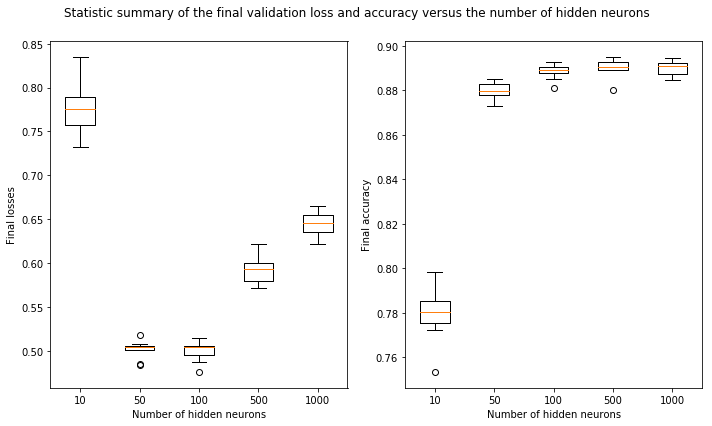

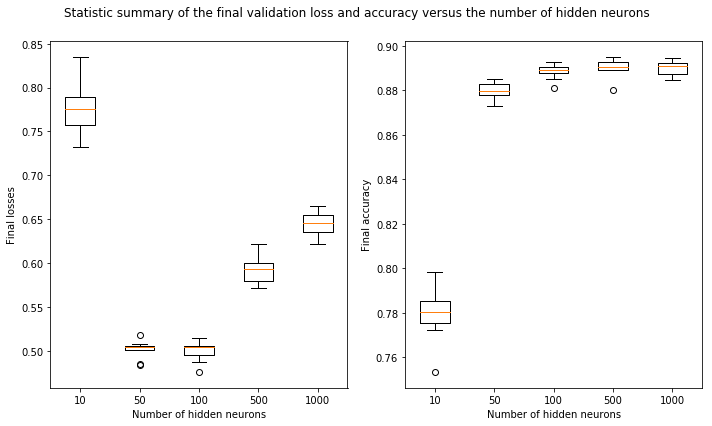

In [92]:
boxplot_plot(losses_100, accuracies_100, 'Statistic summary of the final validation loss and accuracy versus the number of hidden neurons')


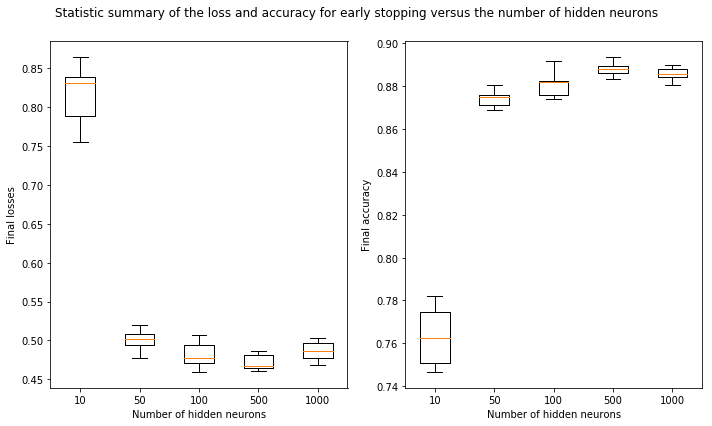

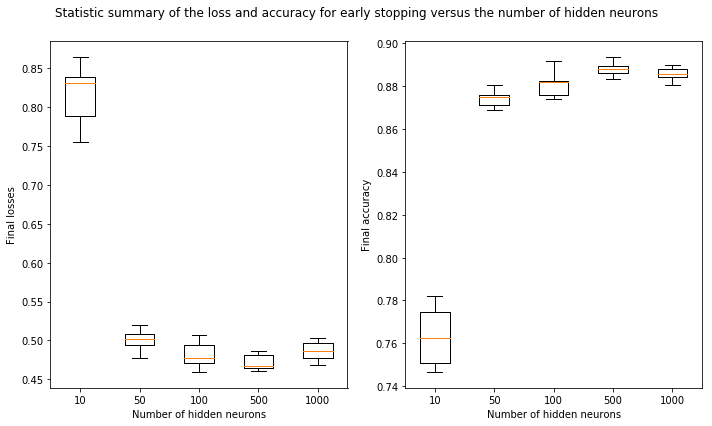

In [93]:
boxplot_plot(losses_ES, accuracies_ES, 'Statistic summary of the loss and accuracy for early stopping versus the number of hidden neurons')

## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

In [44]:
def build_adam_1(learning_rate = 0.001):
    #the model
    model_adam1 = Sequential() # set up empty model
    model_adam1.add(Dense(100, input_dim = 256, activation = 'relu', name = 'H1'))
    model_adam1.add(Dense(5, activation='softmax', name = 'Y'))

    adams = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model_adam1.compile(loss='categorical_crossentropy', optimizer=adams, metrics=['accuracy'])
    #model.summary()
    
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose = 0, mode='min')
    callbacks_list = [earlystop]
    history_adam1 = model_adam1.fit(x_train, y_train, epochs= 150, batch_size=128, callbacks = callbacks_list, verbose=0, validation_data = (x_test, y_test))
    
    return history_adam1
    return model

In [45]:
#build two hidden layer model with optimizer Adam
def build_adam_2(learning_rate = 0.001):
    model_adam2 = Sequential() # set up empty model
    model_adam2.add(Dense(77, input_dim = 256, activation = 'relu', name = 'H1'))
    model_adam2.add(Dense(77, activation = 'relu', name = 'H2'))
    model_adam2.add(Dense(5, activation='softmax', name = 'Y'))
    
    
    adam = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model_adam2.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
    #model_adam2.summary()
    
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose = 0, mode='min')
    callbacks_list = [earlystop]
    history_adam2 = model_adam2.fit(x_train, y_train, epochs= 150, batch_size=128, callbacks = callbacks_list, verbose=0, validation_data = (x_test, y_test))
    
    return history_adam2

In [46]:
#build one hidden layer model with optimizer Adam
def build_adam_3(learning_rate = 0.001):
    model_adam3 = Sequential() # set up empty model
    model_adam3.add(Dense(66, input_dim = 256, activation = 'relu', name = 'H1'))
    model_adam3.add(Dense(66, activation = 'relu', name = 'H2'))
    model_adam3.add(Dense(66, activation = 'relu', name = 'H3'))
    model_adam3.add(Dense(5, activation='softmax', name = 'Y'))
    
    adam = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model_adam3.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
    #model_adam3.summary()
    
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose = 0, mode='min')
    callbacks_list = [earlystop]
    history_adam3 = model_adam3.fit(x_train, y_train, epochs= 150, batch_size=128, callbacks = callbacks_list, verbose=0, validation_data = (x_test, y_test))
    
    return history_adam3

In [47]:
#build one hidden layer model with optimizer Adam
def build_adam_4(learning_rate = 0.001):
    model_adam4 = Sequential() # set up empty model
    model_adam4.add(Dense(59, input_dim = 256, activation = 'relu', name = 'H1'))
    model_adam4.add(Dense(59, activation = 'relu', name = 'H2'))
    model_adam4.add(Dense(59, activation = 'relu', name = 'H3'))
    model_adam4.add(Dense(59, activation = 'relu', name = 'H4'))
    model_adam4.add(Dense(5, activation='softmax', name = 'Y'))
    
    adam = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model_adam4.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
    #model_adam.summary()
    
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose = 0, mode='min')
    callbacks_list = [earlystop]
    history_adam4 = model_adam4.fit(x_train, y_train, epochs= 150, batch_size=128, callbacks = callbacks_list, verbose=0, validation_data = (x_test, y_test))
    
    return history_adam4

In [48]:
nb_time = 10;

val_loss_end = np.empty([nb_time, 4])
val_acc_end = np.empty([nb_time, 4])
val_loss_best = np.empty([nb_time, 4])
val_acc_best = np.empty([nb_time, 4])

start = time.time()
print("Start of the script execution...")

for i in range (0,nb_time):
    hist1 = build_adam_1()
    hist2 = build_adam_2() 
    hist3 = build_adam_3()
    hist4 = build_adam_4()
    
    val_loss_end[i][0] = hist1.history['val_loss'][-1]
    val_loss_end[i][1] = hist2.history['val_loss'][-1]
    val_loss_end[i][2] = hist3.history['val_loss'][-1]
    val_loss_end[i][3] = hist4.history['val_loss'][-1]
    
    val_acc_end[i][0] = hist1.history['val_acc'][-1]
    val_acc_end[i][1] = hist2.history['val_acc'][-1]
    val_acc_end[i][2] = hist3.history['val_acc'][-1]
    val_acc_end[i][3] = hist4.history['val_acc'][-1]
    
    val_loss_best[i][0] = min(hist1.history['val_loss'])
    val_loss_best[i][1] = min(hist2.history['val_loss'])
    val_loss_best[i][2] = min(hist3.history['val_loss'])
    val_loss_best[i][3] = min(hist4.history['val_loss'])
    
    val_acc_best[i][0] = max(hist1.history['val_acc'])
    val_acc_best[i][1] = max(hist2.history['val_acc'])
    val_acc_best[i][2] = max(hist3.history['val_acc'])
    val_acc_best[i][3] = max(hist4.history['val_acc'])
    
print("End of the execution !")
end = time.time()
print("Execution time : {} seconds.".format(math.ceil(end - start)))   
    

Start of the script execution...
End of the execution !
Execution time : 3180 seconds.


In [49]:
np.save('E_5_val_loss_end', val_loss_end)
np.save('E_5_val_acc_end',val_acc_end)
np.save('E_5_val_loss_end', val_loss_best)
np.save('E_5_val_acc_end', val_acc_best)

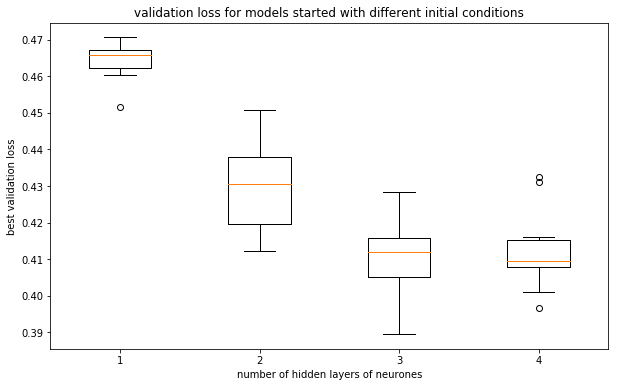

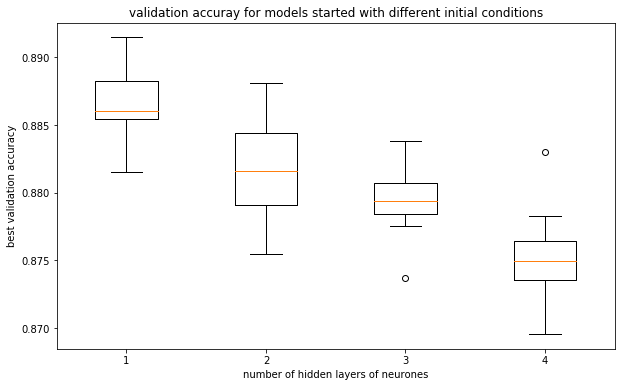

In [50]:
plt.figure()
plt.boxplot(val_loss_best)
plt.title('validation loss for models started with different initial conditions')
plt.ylabel('best validation loss')
plt.xlabel('number of hidden layers of neurones')
plt.savefig('E5 number of hidden layer for end validation loss')

plt.figure()
plt.boxplot(val_acc_best)
plt.title('validation accuray for models started with different initial conditions')
plt.ylabel('best validation accuracy')
plt.xlabel('number of hidden layers of neurones')
plt.savefig('E5 number of hidden layer for end validation accuracy')


## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

In [8]:
epochs_nb = 200

In [9]:
def one_layer(learning_rate = 0.001, hidden_units = 100):
    #the model
    model = Sequential() # set up empty model
    model.add(Dense(hidden_units, input_dim = 256, activation = 'relu', name = 'H1'))
    model.add(Dense(5, activation='softmax', name = 'Y'))

    adams = keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=adams, metrics=['accuracy'])
    
    history = model.fit(x_train, y_train, epochs= epochs_nb , batch_size=128, verbose=0, validation_data = (x_test, y_test))
    
    return history

In [10]:
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.layers import Dropout

def four_layer(learning_rate = 0.001):
    model = Sequential() # set up empty model
    model.add(Dense(59, input_dim = 256, activation = 'relu', name = 'H1'))
    model.add(Dense(59, activation = 'relu', name = 'H2'))
    model.add(Dense(59, activation = 'relu', name = 'H3'))
    model.add(Dense(59, activation = 'relu', name = 'H4'))
    model.add(Dense(5, activation='softmax', name = 'Y'))
    
    adam = keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    history = model.fit(x_train, y_train, epochs= epochs_nb , batch_size=128, verbose=0, validation_data = (x_test, y_test))
    
    return history

In [11]:
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.layers import Dropout

def one_layer_improve_test(learning_rate = 0.001, dropout = 0):
    model = Sequential() 
    model.add(BatchNormalization(input_shape = (256,)))
    model.add(Dense(100, input_dim = 256, activation = 'relu', name = 'H1'))  
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(5, activation='softmax', name = 'Y'))

    adams = keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=adams, metrics=['accuracy'])

    history = model.fit(x_train, y_train, epochs= epochs_nb, batch_size=128, verbose=0, validation_data = (x_test, y_test))
    return history

In [12]:
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.layers import Dropout

def four_layer_improve_test(learning_rate = 0.001, dropout = 0):
    model = Sequential()
    
    model.add(BatchNormalization(input_shape = (256,)))
    model.add(Dense(59, name = 'H1'))
    model.add(Dropout(dropout))

    model.add(Dense(59, activation = 'relu', name = 'H2'))
    model.add(BatchNormalization())

    model.add(Dense(59, activation = 'relu', name = 'H3'))
    model.add(Dropout(dropout))
    
    model.add(Dense(59, activation = 'relu', name = 'H4'))
    model.add(Dropout(dropout))
    
    model.add(Dense(5, activation='softmax', name = 'Y'))
    
    adam = keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    history = model.fit(x_train, y_train, epochs= epochs_nb, batch_size=128, verbose=0, validation_data = (x_test, y_test))
    
    return history

In [13]:
def plot_history_test(history1,history2, title):
    #history1 = sgd
    #history2 = adam
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history1.history['loss'],':', fillstyle='none', color="blue", 
             label = "training naive")
    ax1.plot(history1.history['val_loss'], '--', fillstyle='none', color="blue", 
             label = "validation naive")
    ax1.plot(history2.history['loss'],':', fillstyle='none', color="orange", 
             label = "training new")
    ax1.plot(history2.history['val_loss'], '--', fillstyle='none', color="orange",  
             label = "validation new")
    ax2.plot(history1.history['acc'],':' ,fillstyle='none',color="blue", 
             label = "training naive")
    ax2.plot(history1.history['val_acc'], '--', fillstyle='none', color="blue",
             label = "validation naive")
    ax2.plot(history2.history['acc'], ':', fillstyle='none', color="orange",
             label = "training new")
    ax2.plot(history2.history['val_acc'], '--', fillstyle='none', color="orange", 
             label = "validation new")
    finalize_standardplot(fig, ax1, ax2)
    return fig

In [14]:
def plot_history_layers(history1,history2, title):
    #history1 = sgd
    #history2 = adam
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history1.history['loss'],':', fillstyle='none', color="blue", 
             label = "training 1 layer")
    ax1.plot(history1.history['val_loss'], '--', fillstyle='none', color="blue", 
             label = "validation 1 layer")
    ax1.plot(history2.history['loss'],':', fillstyle='none', color="orange", 
             label = "training 4 layer")
    ax1.plot(history2.history['val_loss'], '--', fillstyle='none', color="orange",  
             label = "validation 4 layer")
    ax2.plot(history1.history['acc'],':' ,fillstyle='none',color="blue", 
             label = "training 1 layer")
    ax2.plot(history1.history['val_acc'], '--', fillstyle='none', color="blue",
             label = "validation 1 layer")
    ax2.plot(history2.history['acc'], ':', fillstyle='none', color="orange",
             label = "training 4 layer")
    ax2.plot(history2.history['val_acc'], '--', fillstyle='none', color="orange", 
             label = "validation 4 layer")
    finalize_standardplot(fig, ax1, ax2)
    return fig

In [17]:
# # #
# # #     A grid search was performed to find optimal hyperparamters. With the hyperparmeters found here, we use
# # #
iterations = range(0,5)
dropout_rate = [0.1,0.2,0.3,0.4, 0.5]
penalty = [0, 1e-4, 1e-3]

val_loss_test_1 = np.zeros((len(iterations), len(dropout_rate), len(penalty)))
val_acc_test_1 = np.zeros((len(iterations), len(dropout_rate), len(penalty)))


#one layer model
best_val_acc = 0
best_history_1 =[]

for iteration in iterations:
    for i in range (0,len(dropout_rate)):
            for j in range(0,len(penalty)):

                history_1 = one_layer_improve_test(dropout = dropout_rate[i], 
                                                   l2 = penalty[j])
                #res = 'model 1 layer: dropout_rate = ' + str(dropout_rate[i]) + ', penalty = ' + str(penalty[j]) + ' : val_loss = ' + str(history_1.history['val_loss'][-1]) + ', val_acc = ' + str(history_1.history['val_acc'][-1])
                #print(res)
                if best_val_acc < history_1.history['val_acc'][-1]:
                    best_val_acc = history_1.history['val_acc'][-1]
                    best_history_1 = history_1
                    
                val_loss_test_1[iteration,i,j] = history_1.history['val_loss'][-1]
                val_acc_test_1[iteration,i,j] = history_1.history['val_acc'][-1]
    print('one layer model: ' + str(iteration) + ' finished')
np.save('exo_6_val_loss_1', val_loss_test_1) 
np.save('exo_6_val_acc_1', val_acc_test_1) 


#four layer model

iterations = range(0,1)
dropout_rate = [0.1,0.2,0.3,0.4, 0.5]
penalty = [0, 1e-4]

val_loss_test_4 = np.zeros((len(iterations), len(dropout_rate), len(penalty)))
val_acc_test_4 = np.zeros((len(iterations), len(dropout_rate), len(penalty)))

best_val_acc = 0
best_history_4 = []

for iteration in iterations:
    for i in range (0,len(dropout_rate)):
        for j in range (0,len(penalty)):       
                history_4 = four_layer_improve_test(dropout = dropout_rate[i], 
                                                    l2 = penalty[j])

                #res = 'model 4 layer: dropout_rate = ' + str(dropout_rate[i]) + ', penalty = ' + str(penalty[j]) + ' : val_loss = ' + str(history_4.history['val_loss'][-1]) + ', val_acc = ' + str(history_4.history['val_acc'][-1])
                #print(res)
                if best_val_acc < history_4.history['val_acc'][-1]:
                    best_val_acc = history_4.history['val_acc'][-1]
                    best_history_4 = history_4
                
                val_loss_test_4[iteration,i,j] = history_4.history['val_loss'][-1]
                val_acc_test_4[iteration,i,j] = history_4.history['val_acc'][-1]
    print('four layer model: ' + str(iteration) + ' finished')
np.save('exo_6_val_loss_4_test', val_loss_test_4) 
np.save('exo_6_val_acc_4_test', val_acc_test_4) 


one layer model: 0 finished
one layer model: 1 finished
one layer model: 2 finished
one layer model: 3 finished
one layer model: 4 finished
one layer model: 0 finished
one layer model: 1 finished
one layer model: 2 finished
one layer model: 3 finished
one layer model: 4 finished


In [15]:
history_1 = one_layer()
history_4 = four_layer()
best_history_1 = one_layer_improve_test(dropout = 0.1)
best_history_4 = four_layer_improve_test(dropout = 0.2)

1 LAYER - Validation accuracy - Naive model : 0.891581948921
1 LAYER - Validation accuracy - New model : 0.903111827424


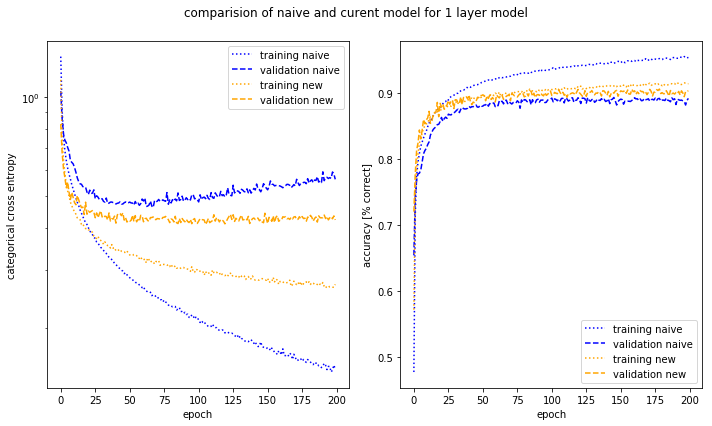

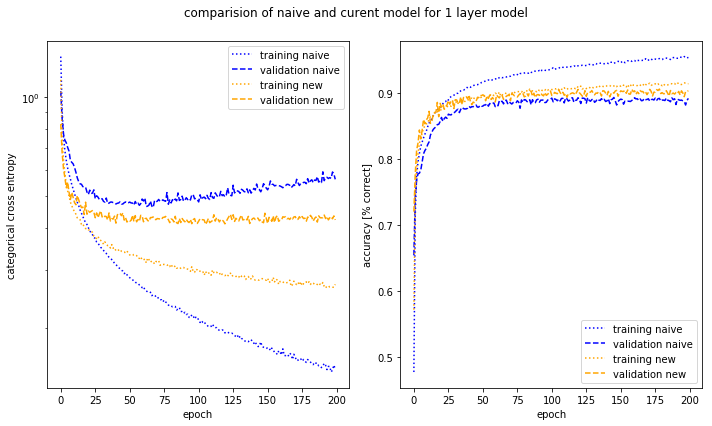

In [19]:
print('1 LAYER - Validation accuracy - Naive model :',history_1.history['val_acc'][-1])
print('1 LAYER - Validation accuracy - New model :',best_history_1.history['val_acc'][-1])
plot_history_test(history_1,best_history_1, 'comparision of naive and curent model for 1 layer model')

4 LAYERS - Validation accuracy - Naive model : 0.871497644433
4 LAYERS - Validation accuracy - New model : 0.907017108852


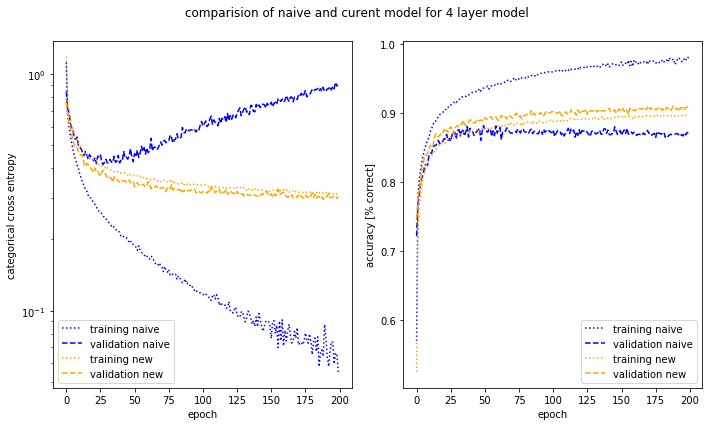

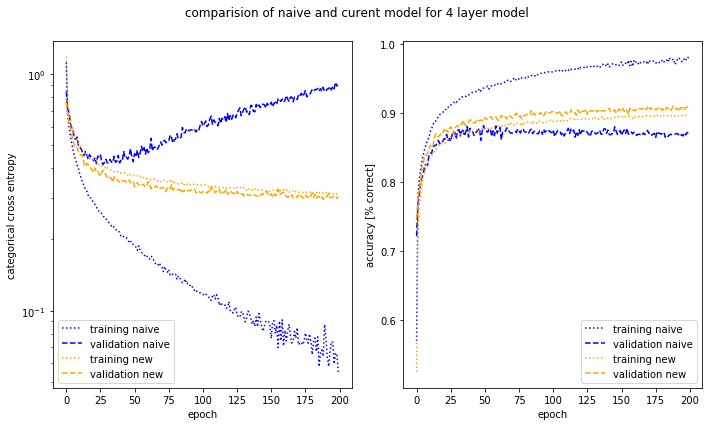

In [20]:
print('4 LAYERS - Validation accuracy - Naive model :',history_4.history['val_acc'][-1])
print('4 LAYERS - Validation accuracy - New model :',best_history_4.history['val_acc'][-1])
plot_history_test(history_4,best_history_4, 'comparision of naive and curent model for 4 layer model')

1 LAYER - Validation accuracy - New model : 0.903111827424
4 LAYERS - Validation accuracy - New model : 0.907017108852


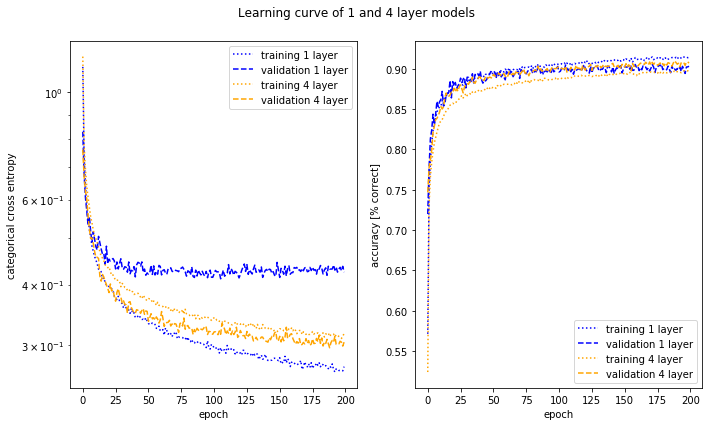

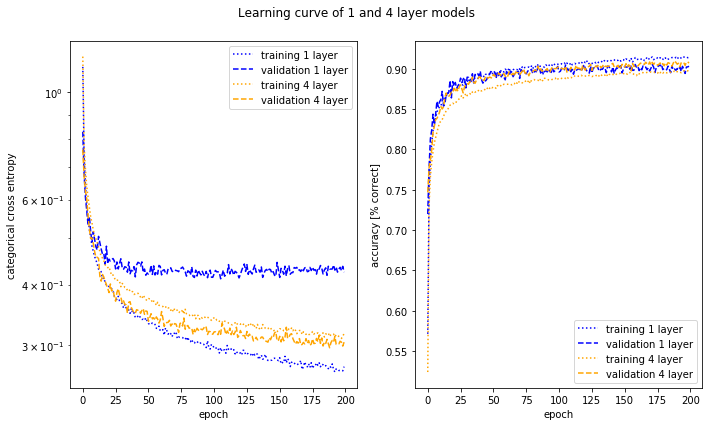

In [21]:
print('1 LAYER - Validation accuracy - New model :',best_history_1.history['val_acc'][-1])
print('4 LAYERS - Validation accuracy - New model :',best_history_4.history['val_acc'][-1])
plot_history_layers(best_history_1,best_history_4, 'Learning curve of 1 and 4 layer models')

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution

In [22]:
from keras import backend as K

batch_size = 128
num_classes = 5
epochs = 20

# input image dimensions
img_rows, img_cols = 16, 16

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

model_CNN = Sequential()
model_CNN.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN.add(Dropout(0.25))

model_CNN.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN.add(Dropout(0.25))

model_CNN.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN.add(Dropout(0.25))

model_CNN.add(Flatten())
model_CNN.add(Dense(254, activation='relu'))
model_CNN.add(Dropout(0.5))
model_CNN.add(Dense(num_classes, activation='softmax'))

model_CNN.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history_CNN = model_CNN.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score_CNN = model_CNN.evaluate(x_test, y_test, verbose=0)

x_train shape: (44513, 16, 16, 1)
44513 train samples
16132 test samples
Train on 44513 samples, validate on 16132 samples
Epoch 1/20
44513/44513 [==============================] - 32s 712us/step - loss: 1.3230 - acc: 0.4433 - val_loss: 0.7557 - val_acc: 0.7212
Epoch 2/20
44513/44513 [==============================] - 30s 667us/step - loss: 0.6306 - acc: 0.7758 - val_loss: 0.3969 - val_acc: 0.8670
Epoch 3/20
44513/44513 [==============================] - 31s 687us/step - loss: 0.4474 - acc: 0.8471 - val_loss: 0.3025 - val_acc: 0.9026
Epoch 4/20
44513/44513 [==============================] - 30s 677us/step - loss: 0.3704 - acc: 0.8774 - val_loss: 0.2561 - val_acc: 0.9182
Epoch 5/20
44513/44513 [==============================] - 31s 690us/step - loss: 0.3340 - acc: 0.8884 - val_loss: 0.2531 - val_acc: 0.9207
Epoch 6/20
44513/44513 [==============================] - 29s 644us/step - loss: 0.3075 - acc: 0.8976 - val_loss: 0.2241 - val_acc: 0.9317
Epoch 7/20
44513/44513 [===================

In [ ]:
# Notes on the convolutional networks:

# first parameters: filter - the dimentionality of the output space

# first layer with lower number of filter catch few of some simple features of 
# images (edge, color tone). The next layers are trying to obtain more complex 
# features based on simple ones. 


Test loss: 0.168570280964
Test accuracy: 0.950967022068
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)   

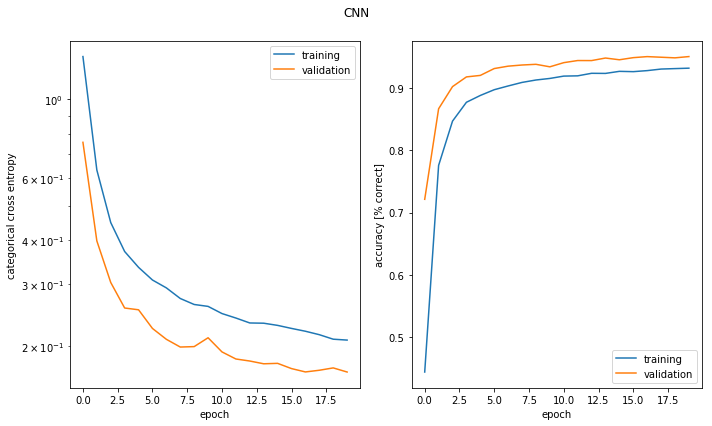

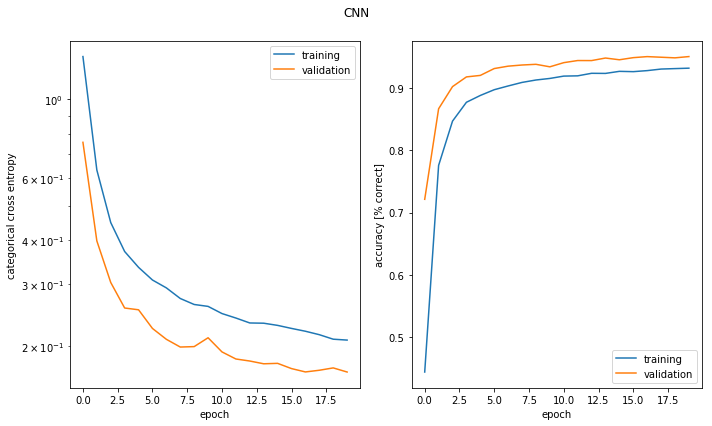

In [23]:
print('Test loss:', score_CNN[0])
print('Test accuracy:', score_CNN[1])

model_CNN.summary()
plot_history(history_CNN,'CNN')

In [24]:
def plot_history_final(history_prev,history_CNN, title):
    #history1 = sgd
    #history2 = adam
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history_prev.history['loss'],':', fillstyle='none', color="blue", 
             label = "training 4 layers regularized")
    ax1.plot(history_prev.history['val_loss'], '--', fillstyle='none', color="blue", 
             label = "validation 4 layers regularized")
    ax1.plot(history_CNN.history['loss'],':', fillstyle='none', color="orange", 
             label = "training CNN")
    ax1.plot(history_CNN.history['val_loss'], '--', fillstyle='none', color="orange",  
             label = "validation CNN")
    ax2.plot(history_prev.history['acc'],':' ,fillstyle='none',color="blue", 
             label = "training 4 layers regularized")
    ax2.plot(history_prev.history['val_acc'], '--', fillstyle='none', color="blue",
             label = "validation 4 layers regularized")
    ax2.plot(history_CNN.history['acc'], ':', fillstyle='none', color="orange",
             label = "training CNN")
    ax2.plot(history_CNN.history['val_acc'], '--', fillstyle='none', color="orange", 
             label = "validation CNN")
    finalize_standardplot(fig, ax1, ax2)
    return fig

4 layers, regularized - Validation accuracy : 0.907017108852
Convolutional neural network - Validation accuracy: 0.950967022068


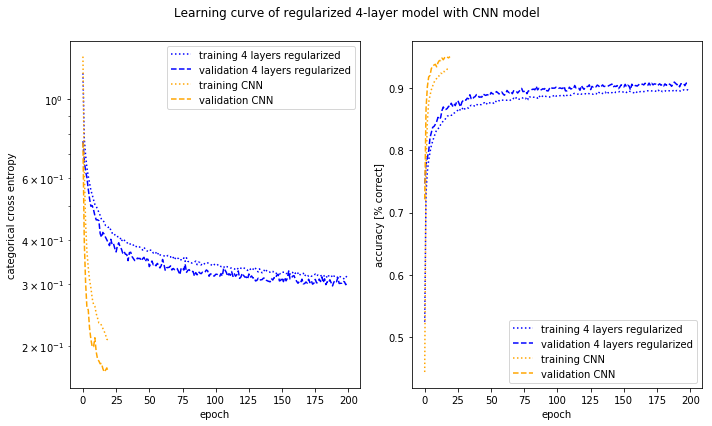

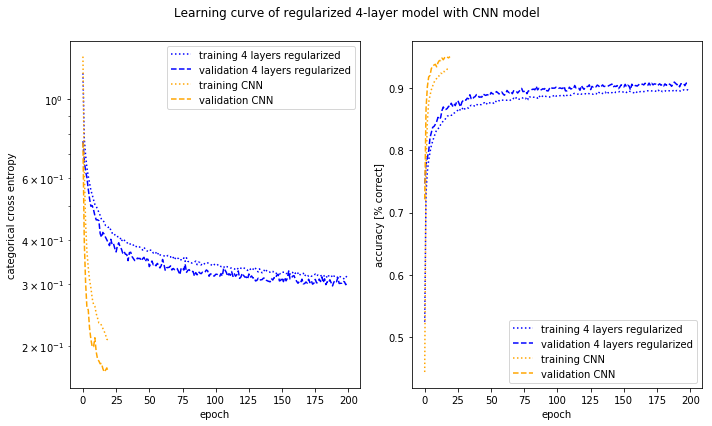

In [42]:
print('4 layers, regularized - Validation accuracy :',best_history_4.history['val_acc'][-1])
print('Convolutional neural network - Validation accuracy:',history_CNN.history['val_acc'][-1])
plot_history_final(best_history_4,history_CNN, 'Learning curve of regularized 4-layer model with CNN model')